In [9]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Some graphical settings, can be skipped

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8

Interesting library to download the data

#pip install gdown

In [11]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: C:\Users\bnawa\train.csv

  0%|          | 0.00/799k [00:00<?, ?B/s]
 66%|######5   | 524k/799k [00:00<00:00, 1.16MB/s]
100%|##########| 799k/799k [00:00<00:00, 1.34MB/s]
100%|##########| 799k/799k [00:00<00:00, 1.37MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: C:\Users\bnawa\valid.csv

  0%|          | 0.00/43.3k [00:00<?, ?B/s]
100%|##########| 43.3k/43.3k [00:00<00:00, 883kB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: C:\Users\bnawa\test.csv

  0%|          | 0.00/43.1k [00:00<?, ?B/s]
100%|##########| 43.1k/43.1k [00:00<00:00, 1.03MB/s]


Prepare dataset. It was prepared and used for below paper:

https://arxiv.org/abs/1805.10190

Intents are below:

-SearchCreativeWork (e.g. Find me the I, Robot television show)

-GetWeather (e.g. Is it windy in Boston, MA right now?)

-BookRestaurant (e.g. I want to book a highly rated restaurant for me and my boyfriend tomorrow night)

-PlayMusic (e.g. Play the last track from Beyoncé off Spotify)

-AddToPlaylist (e.g. Add Diamonds to my roadtrip playlist)

-RateBook (e.g. Give 6 stars to Of Mice and Men)

-SearchScreeningEvent (e.g. Check the showtimes for Wonder Woman in Paris)

In [12]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

train = train.append(valid).reset_index(drop=True)

In [13]:
train.describe()

,text,intent
count,13784,13784
unique,13543,7
top,find movie times,PlayMusic
freq,13,2014


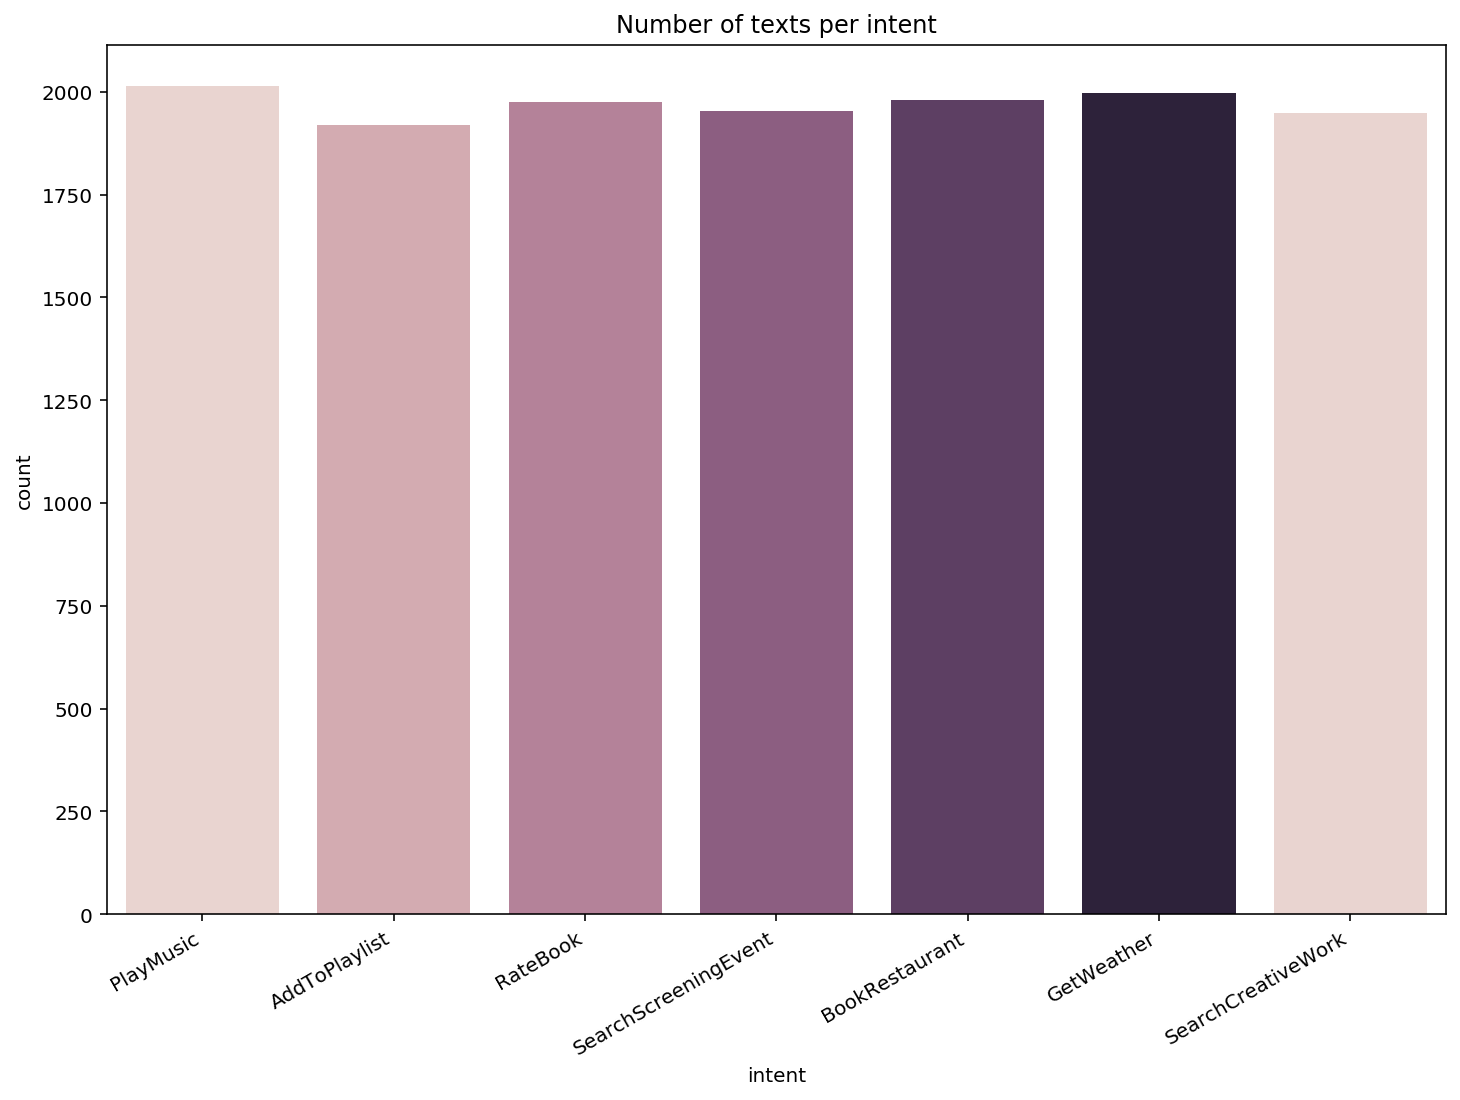

In [14]:
chart = sns.countplot(train.intent, palette=sns.cubehelix_palette())
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

Intent Recognition with BERT

In [15]:
#Make directories with the data
import os
os.makedirs("model", exist_ok=True)

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

Preprocess the data. This class is inspired by https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb

In [16]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [17]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

Create a model with BERT layer and fine-tuning it

In [21]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

Train 

In [23]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:03, 4383.78it/s]
700it [00:00, 2999.08it/s]

max seq_len 38


In [24]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x000002105D1A1B08> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [26]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [30]:
#log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5)

Train on 12405 samples, validate on 1379 samples
Epoch 1/5
12405/12405 [==============================] - 536s 43ms/sample - loss: 1.3010 - acc: 0.8783 - val_loss: 1.1701 - val_acc: 0.9964
Epoch 2/5
12405/12405 [==============================] - 513s 41ms/sample - loss: 1.1839 - acc: 0.9832 - val_loss: 1.1704 - val_acc: 0.9956
Epoch 3/5
12405/12405 [==============================] - 517s 42ms/sample - loss: 1.1788 - acc: 0.9873 - val_loss: 1.1703 - val_acc: 0.9956
Epoch 4/5
12405/12405 [==============================] - 513s 41ms/sample - loss: 1.1779 - acc: 0.9878 - val_loss: 1.1686 - val_acc: 0.9964
Epoch 5/5
12405/12405 [==============================] - 503s 41ms/sample - loss: 1.1755 - acc: 0.9902 - val_loss: 1.1683 - val_acc: 0.9971


In [31]:
%load_ext tensorboard

Loss

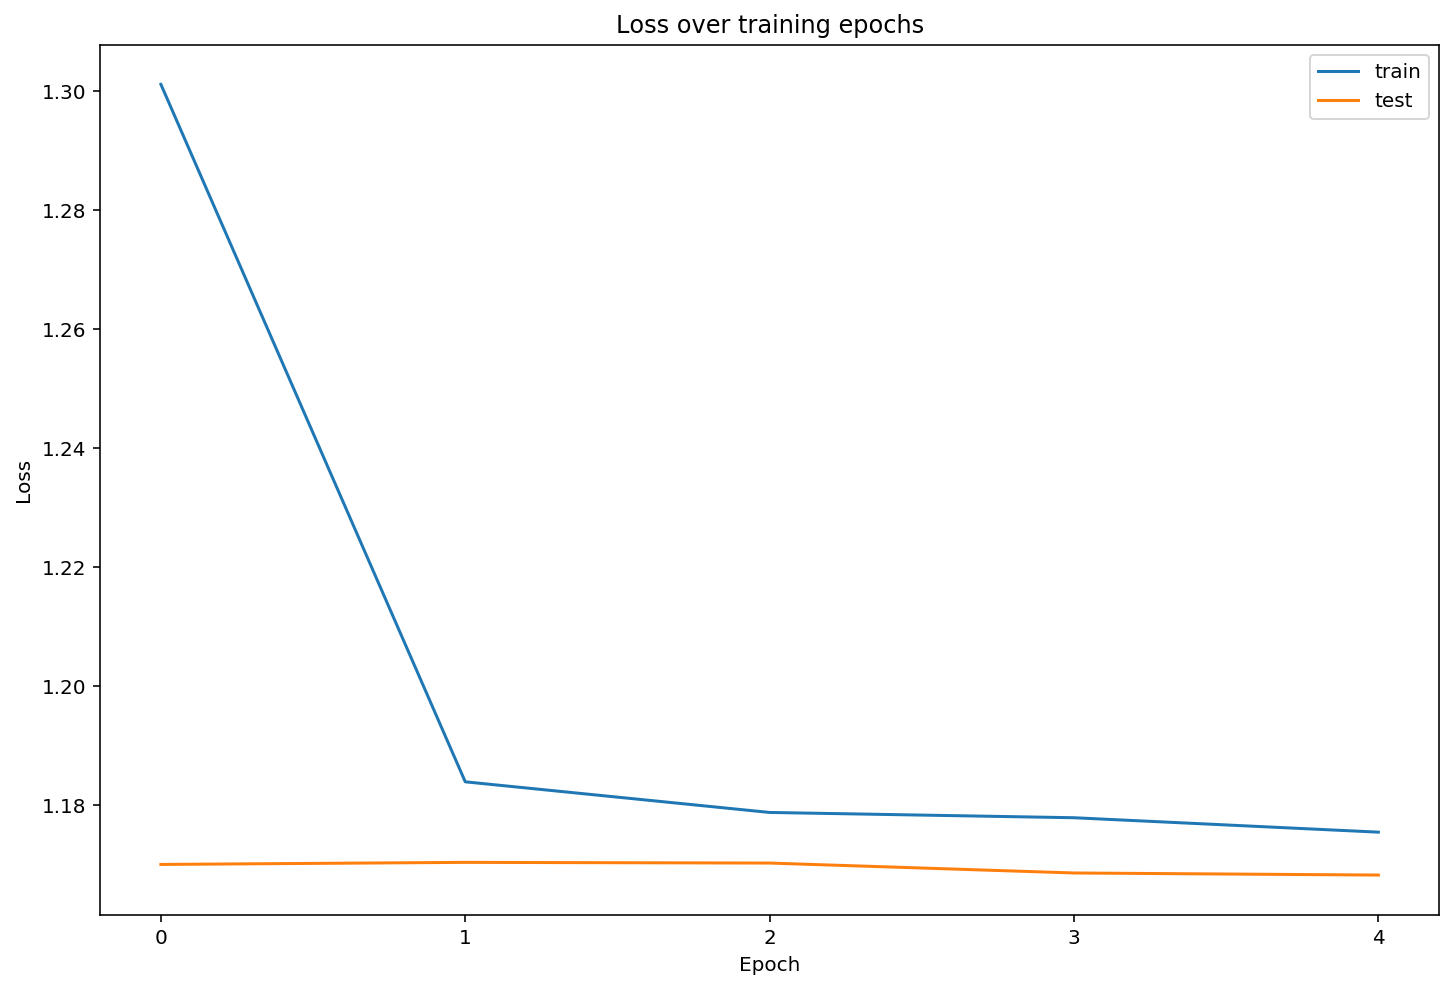

In [33]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Accuracy

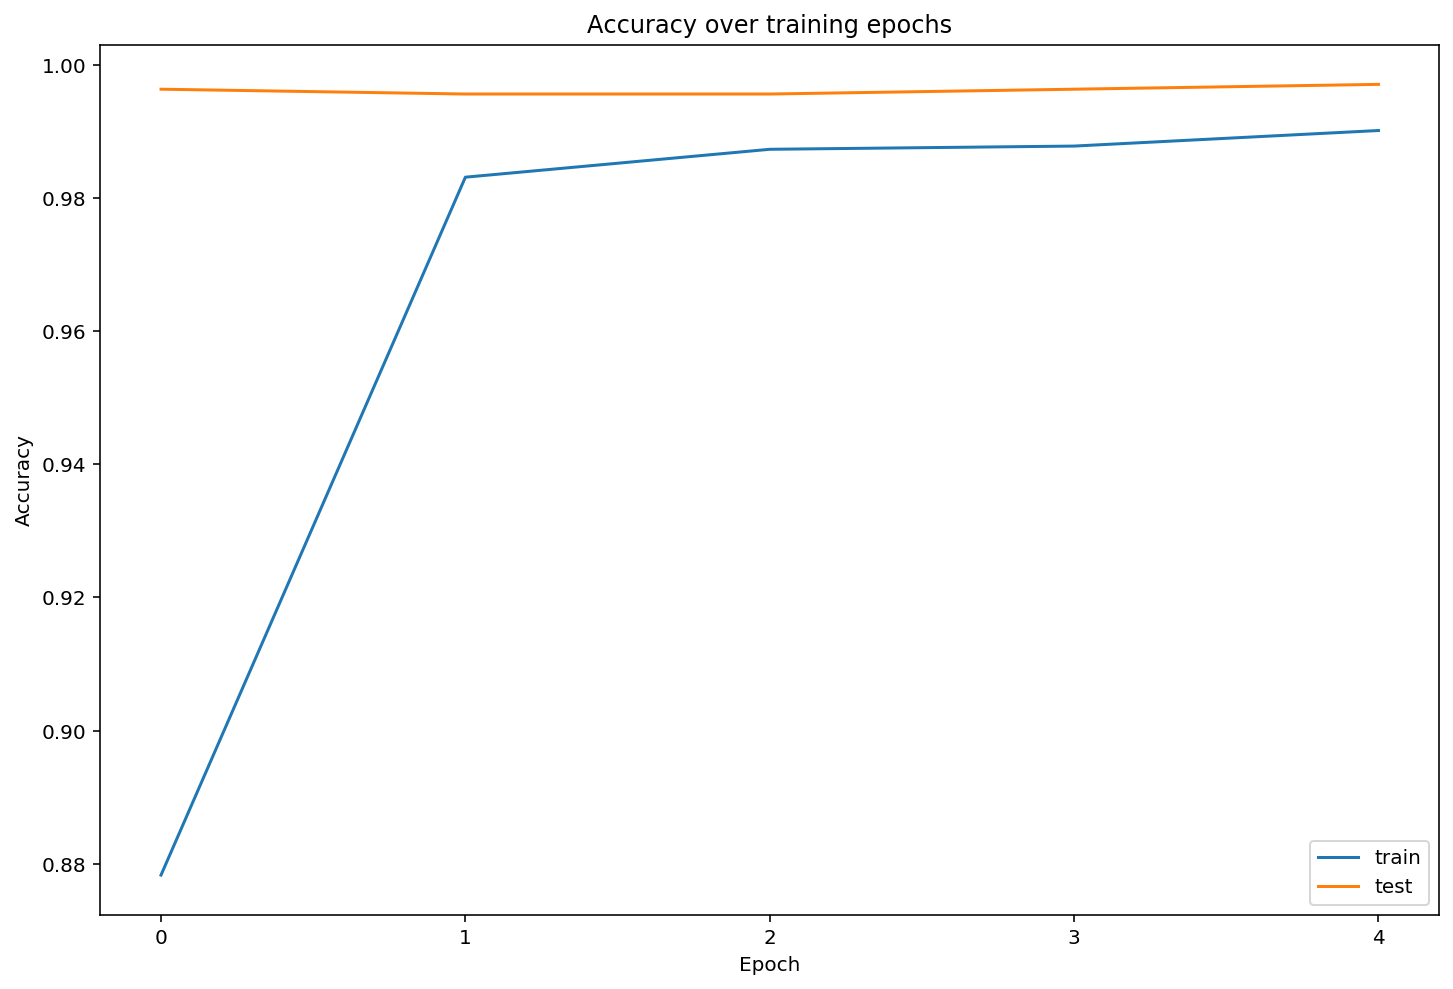

In [34]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [35]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

700/700 [==============================] - 6s 9ms/sample - loss: 1.1938 - acc: 0.9714
train acc 0.99347067
test acc 0.9714286


In [39]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [40]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.93      0.98      0.95        86
       AddToPlaylist       0.99      0.98      0.99       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       0.99      0.92      0.95       107
      BookRestaurant       0.98      1.00      0.99        92
          GetWeather       1.00      0.98      0.99       104
  SearchCreativeWork       0.91      0.95      0.93       107

            accuracy                           0.97       700
           macro avg       0.97      0.97      0.97       700
        weighted avg       0.97      0.97      0.97       700



Take a look at the confusion matrix

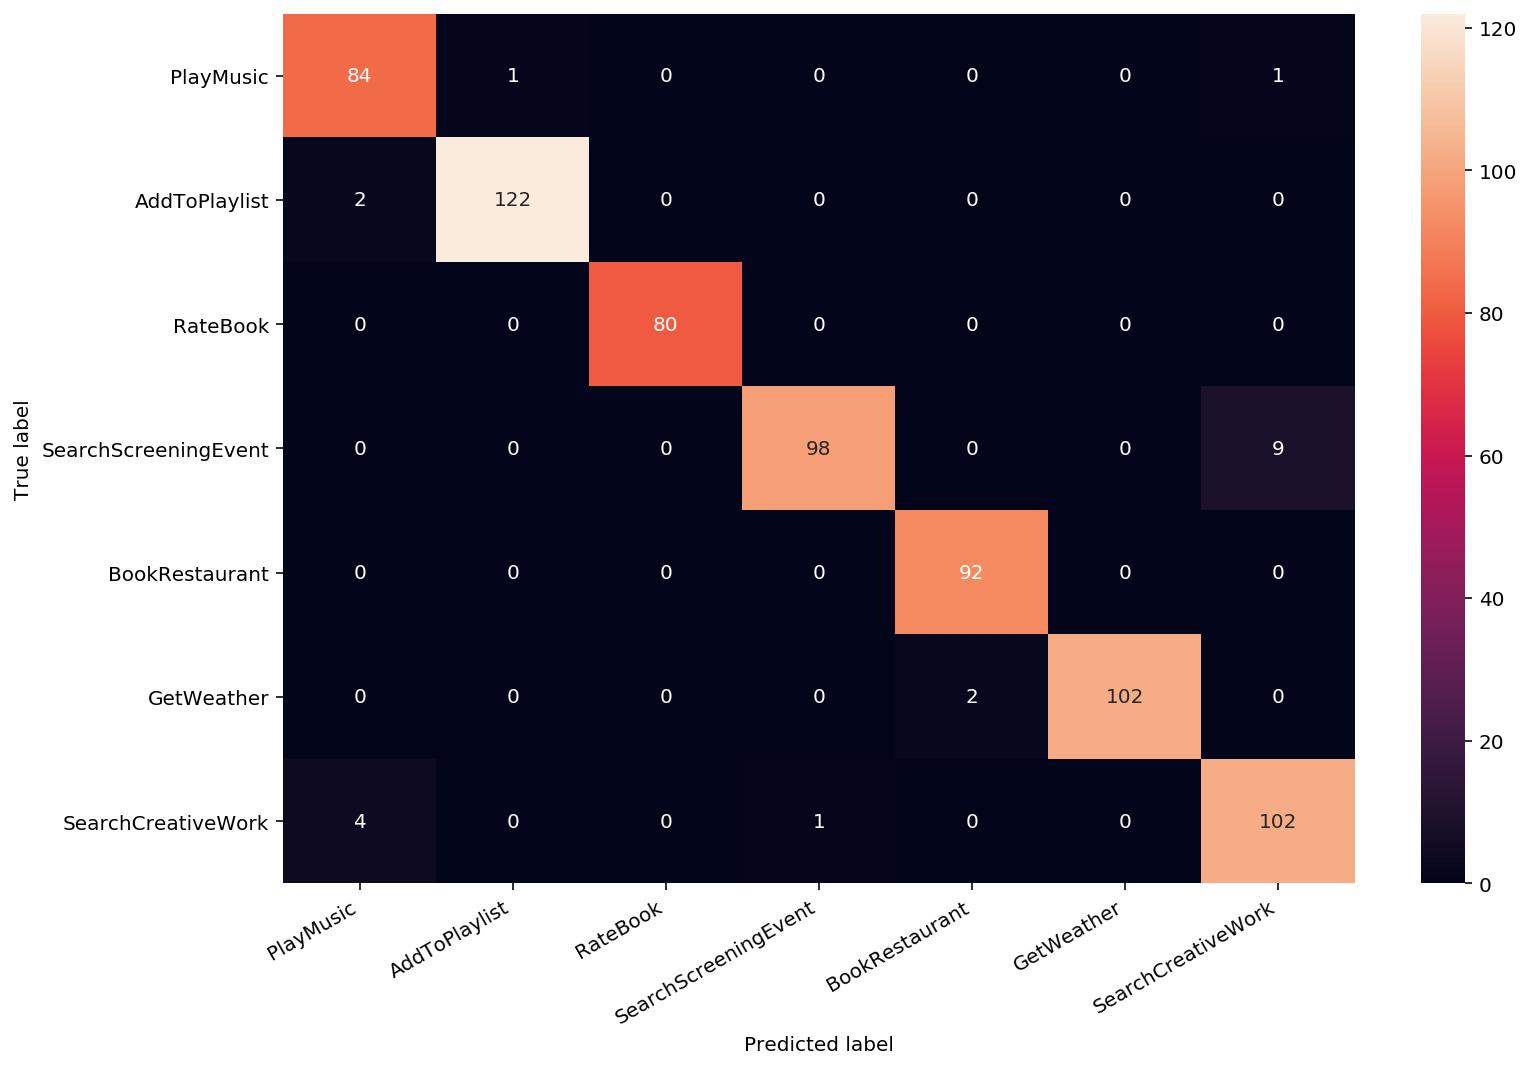

In [41]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

Try to predict some sentences

In [51]:

sentences = [
  "Is Ernest Hemingway any good?",
  "Play something",
    "This evening pizza",
    "save this for later"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Is Ernest Hemingway any good? 
intent: SearchCreativeWork

text: Play something 
intent: PlayMusic

text: This evening pizza 
intent: BookRestaurant

text: save this for later 
intent: AddToPlaylist



References:

https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb

https://www.kdnuggets.com/2020/02/intent-recognition-bert-keras-tensorflow.html